In [1]:
from keras.callbacks import EarlyStopping
from pmdarima.utils import diff_inv
import statsmodels.api as sm
import statsmodels
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import LSTM,Dense
from tensorflow.keras.models import Sequential,load_model
from statsmodels.tsa.arima_process import arma_generate_sample
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from tensorflow import keras
from collections import Counter
import random
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
np.seterr(divide='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

cin=np.concatenate((c1in,c2in,c3in,c4in,c5in,c6in),axis=0)
coutb=np.concatenate((c1outb,c2outb,c3outb,c4outb,c5outb,c6outb),axis=0)
coutm=np.concatenate((c1outm,c2outm,c3outm,c4outm,c5outm,c6outm),axis=0)
export_df(cin,'cin')
export_df(coutb,'coutb')
export_df(coutb,'coutb')

In [33]:
def arima_sim(ar,ma,diff_order,nsample):
    if diff_order ==0:
        sample=arma_generate_sample(ar=ar,ma=ma,nsample=nsample)
    elif diff_order==1:
        x=arma_generate_sample(ar=ar,ma=ma,nsample=nsample)
        sample=diff_inv(x,lag=1,differences=diff_order)[1:]
    elif diff_order==2:
        x=arma_generate_sample(ar=ar,ma=ma,nsample=nsample) ## 하늘 바라기 하늘만 멍하니 가장 큰 하늘이 있잖아. 그대가 
        sample=diff_inv(x,lag=1,differences=diff_order)[2:] ## 아니 잠시만 씨발 이게 무슨 일이여 diff_inv잘못 짰는디?
    return sample

def acc_cal(test,true):
    assert test.shape==true.shape
    cnt=0
    length=true.shape[-1]
    for x,y in zip(test,true):
        if sum(x==y)==length:
            cnt+=1
    return cnt/true.shape[0]

def to_put(array,timesteps):
    array=array[:,:timesteps]
    array=array.reshape((array.shape[0],array.shape[1],1))
    return array

def to_in(series,timesteps):
    series=series[:timesteps]
    series=series.reshape(1,timesteps,1)
    return series

def data_split(array,split_1,split_2):
    trset=array[:split_1]
    valset=array[split_1:split_2]
    teset=array[split_2:]
    return trset,valset,teset

def load_d2set(p1,p2,split_1,split_2):
    # 
    inputs=pd.read_csv('c:/data/dataset/din_{}_{}.csv'.format(p1,p2),header=None).to_numpy()
    outb=pd.read_csv('c:/data/dataset/doutb_{}_{}.csv'.format(p1,p2),header=None).to_numpy()
    outm=pd.read_csv('c:/data/dataset/doutm_{}_{}.csv'.format(p1,p2),header=None).to_numpy()
    #
    return data_split(inputs,split_1,split_2),data_split(outb,split_1,split_2),data_split(outm,split_1,split_2)
# in ,outb,outm순
def load_c2set(p1,p2,split_1,split_2):
    # 
    inputs=pd.read_csv('c:/data/dataset/cin_{}_{}.csv'.format(p1,p2),header=None).to_numpy()
    outb=pd.read_csv('c:/data/dataset/coutb_{}_{}.csv'.format(p1,p2),header=None).to_numpy()
    outm=pd.read_csv('c:/data/dataset/coutm_{}_{}.csv'.format(p1,p2),header=None).to_numpy()
    #
    return data_split(inputs,split_1,split_2),data_split(outb,split_1,split_2),data_split(outm,split_1,split_2)

def export_df(array,name):
    df=pd.DataFrame(array)
    basic_direc=r"c:/data/dataset/"
    direc=basic_direc+name+".csv"
    df.to_csv(direc,index=None,header=False)
        
def shuffle_rows(arr):
    shuffled_arr = arr.copy()
    np.random.shuffle(shuffled_arr)
    return shuffled_arr

In [3]:
def sort_ur(inputs):
    indices_ur=[]
    indices_stationary=[]
    for i,x in enumerate(inputs):
        if x[-1]==0:
            indices_stationary.append(i)
        else:
            indices_ur.append(i)
    return indices_ur,indices_stationary

In [5]:
## 사실 이게 병신코드임 idx만 뽑으면 다 노상관인데 ㅋㅋ
def sort_H1(inputs,outputs): # sorting unit root series for calculating empirical size
    inputs_sorted=[]
    outputs_sorted=[]
    indices=[]
    for i,x,y in zip(range(len(inputs)),inputs,outputs):
        if y[-1]==1:
            inputs_sorted.append(x)
            outputs_sorted.append(y)
            indices.append(i)
    inputs_sorted=np.array(inputs_sorted)
    outputs_sorted=np.array(outputs_sorted)
    return inputs_sorted,outputs_sorted,indices
def sort_H0(inputs,outputs): # sorting unit root series for calculating empirical size
    inputs_sorted=[]
    outputs_sorted=[]
    indices=[]
    for i,x,y in zip(range(len(inputs)),inputs,outputs):
        if y[-1]==0:
            inputs_sorted.append(x)
            outputs_sorted.append(y)
            indices.append(i)
    inputs_sorted=np.array(inputs_sorted)
    outputs_sorted=np.array(outputs_sorted)
    return inputs_sorted,outputs_sorted,indices

In [5]:
## table은 기본적으로 binary classification 기준
def  table_acc(model,input_set,output_set,adf_set):
        result={}
        classifier_acc=[]
        for inputs,outputs in zip(input_set,output_set):
            classifier_acc.append(np.round(model.evaluate(to_put(inputs,100),outputs)[1],3))
        result['model']=classifier_acc

        acc_adf1=[]
        for adf,outputs in zip(adf_set,output_set):
            acc_adf1.append(acc_cal(adf['1%']['bi'],outputs))
        result['adf_1%']=acc_adf1    
        acc_adf5=[]
        for adf,outputs in zip(adf_set,output_set):
            acc_adf5.append(acc_cal(adf['5%']['bi'],outputs))
        result['adf_5%']=acc_adf5
        acc_adf10=[]
        for adf,outputs in zip(adf_set,output_set):
            acc_adf10.append(acc_cal(adf['10%']['bi'],outputs))
        result['adf_10%']=acc_adf10        
        return result

In [6]:
## multi acc
def  table_accm(model,input_set,output_set,adf_set):
        result={}
        classifier_acc=[]
        for inputs,outputs in zip(input_set,output_set):
            classifier_acc.append(np.round(model.evaluate(to_put(inputs,100),outputs)[1],3))
        result['model']=classifier_acc
        acc_adf1=[]
        for adf,outputs in zip(adf_set,output_set):
            acc_adf1.append(acc_cal(adf['1%']['multi'],outputs))
        result['adf_1%']=acc_adf1    
        acc_adf5=[]
        for adf,outputs in zip(adf_set,output_set):
            acc_adf5.append(acc_cal(adf['5%']['multi'],outputs))
        result['adf_5%']=acc_adf5
        acc_adf10=[]
        for adf,outputs in zip(adf_set,output_set):
            acc_adf10.append(acc_cal(adf['10%']['multi'],outputs))
        result['adf_10%']=acc_adf10        
        return result

### zin adf

In [34]:
def adf_rtest(array): #두 번의 adf test에서 같은 significance level 사용/sig=0 => 1%/ sig=1=>5%/sig=2 => 10%
    array=array[:,:100] # 
    assert array.shape[1]
    adf_test_result={}
    critical_value=sm.tsa.adfuller(array[0,:100],regression='n')[4]
#    critical_value={'1%':-2.33,'5%':-1.65,'10%':-1.28}
    for sig_level in ['1%','5%','10%']: # critical value at sig.level 1%,5%,10% each
        dic=defaultdict(np.array)
        bi=[]
        multi=[]
        for i in range(0,array.shape[0]):
            test_result=sm.tsa.adfuller(array[i],regression='n')
            tval=test_result[0]
            c_value=critical_value[sig_level]
            if tval>=c_value:
                bi.append([1,0])
                tval_diff=sm.tsa.adfuller(np.diff(array[i]),regression='n')[0]
                if tval_diff>=c_value:
                    multi.append([1,0,0]) ## diff order 2
                else:
                    multi.append([0,1,0]) ## diff order 1
            else:
                bi.append([0,1])
                multi.append([0,0,1])
        dic['bi']=np.array(bi)
        dic['multi']=np.array(multi)
        #
        adf_test_result[sig_level]=dic
    return adf_test_result

In [7]:
def adf_test(array): #두 번의 adf test에서 같은 significance level 사용/sig=0 => 1%/ sig=1=>5%/sig=2 => 10%
    array=array[:,:100] # 
    assert array.shape[1]
    adf_test_result={}
    critical_value={'1%':-2.33,'5%':-1.65,'10%':-1.28}
    for sig_level in ['1%','5%','10%']: # critical value at sig.level 1%,5%,10% each
        dic=defaultdict(np.array)
        bi=[]
        multi=[]
        for i in range(0,array.shape[0]):
            test_result=sm.tsa.adfuller(array[i],regression='n')
            tval=test_result[0]
            c_value=critical_value[sig_level]
            if tval>=c_value:
                bi.append([1,0])
                tval_diff=sm.tsa.adfuller(np.diff(array[i]),regression='n')[0]
                if tval_diff>=c_value:
                    multi.append([1,0,0]) ## diff order 2
                else:
                    multi.append([0,1,0]) ## diff order 1
            else:
                bi.append([0,1])
                multi.append([0,0,1])
        dic['bi']=np.array(bi)
        dic['multi']=np.array(multi)
        #
        adf_test_result[sig_level]=dic
    return adf_test_result

In [8]:
def model_size(model,inputs,outputs):
    in0,out0,idx0=sort_H0(inputs,outputs)
    size=np.round(np.sum(np.round(model.predict(to_put(in0,100))),axis=0)[1]/len(idx0),3)
    return size
def adf_size(adf,inputs,outputs,sig):
    in0,out0,idx0=sort_H0(inputs,outputs)
    size=np.round(np.sum(adf[sig]['bi'][idx0],axis=0)[1]/len(idx0),3)
    return size
def model_power(model,inputs,outputs):
    in1,out1,idx1=sort_H1(inputs,outputs)
    power=np.round(np.sum(np.round(model.predict(to_put(in1,100))),axis=0)[1]/len(idx1),3)
    return power
def adf_power(adf,inputs,outputs,sig):
    in1,out1,idx1=sort_H1(inputs,outputs)
    power=np.round(np.sum(adf[sig]['bi'][idx1],axis=0)[1]/len(idx1),3)
    return power

def  table_macc(model,input_set,output_set,adf_set):
        result={}
        classifier_acc=[]
        for inputs,outputs in zip(input_set,output_set):
            classifier_acc.append(np.round(model.evaluate(to_put(inputs[2],100),outputs[2])[1],3))
        result['model']=classifier_acc

        acc_adf1=[]
        for adf,outputs in zip(adf_set,output_set):
            acc_adf1.append(acc_cal(adf['1%']['multi'],outputs[2]))
        result['adf_1%']=acc_adf1    
        acc_adf5=[]
        for adf,outputs in zip(adf_set,output_set):
            acc_adf5.append(acc_cal(adf['5%']['multi'],outputs[2]))
        result['adf_5%']=acc_adf5
        acc_adf10=[]
        for adf,outputs in zip(adf_set,output_set):
            acc_adf10.append(acc_cal(adf['10%']['multi'],outputs[2]))
        result['adf_10%']=acc_adf10
        
        return result

In [9]:
def  table_size(model,input_set,output_set,adf_set):
        result={}
        classifier_size=[]
        for inputs,outputs in zip(input_set,output_set):
            classifier_size.append(model_size(model,inputs,outputs))
        result['model']=classifier_size
        size_adf1=[]
        for adf,inputs,outputs in zip(adf_set,input_set,output_set):
            size_adf1.append(adf_size(adf,inputs,outputs,'1%'))
        result['adf_1%']=size_adf1
        size_adf5=[]
        for adf,inputs,outputs in zip(adf_set,input_set,output_set):
            size_adf5.append(adf_size(adf,inputs,outputs,'5%'))
        result['adf_5%']=size_adf5
        size_adf10=[]
        for adf,inputs,outputs in zip(adf_set,input_set,output_set):
            size_adf10.append(adf_size(adf,inputs,outputs,'10%'))
        result['adf_10%']=size_adf10
        return result
def adf_size(adf,inputs,outputs,sig):
    in0,out0,idx0=sort_H0(inputs,outputs)
    size=np.round(np.sum(adf[sig]['bi'][idx0],axis=0)[1]/len(idx0),3)
    return size

In [10]:
def  table_power(model,input_set,output_set,adf_set):
        result={}
        classifier_power=[]
        for inputs,outputs in zip(input_set,output_set):
            classifier_power.append(model_power(model,inputs,outputs))
        result['model']=classifier_power

        power_adf1=[]
        for adf,inputs,outputs in zip(adf_set,input_set,output_set):
            power_adf1.append(adf_power(adf,inputs,outputs,'1%'))
        result['adf_1%']=power_adf1
        
        power_adf5=[]
        for adf,inputs,outputs in zip(adf_set,input_set,output_set):
            power_adf5.append(adf_power(adf,inputs,outputs,'5%'))
        result['adf_5%']=power_adf5
        
        power_adf10=[]
        for adf,inputs,outputs in zip(adf_set,input_set,output_set):
            power_adf10.append(adf_power(adf,inputs,outputs,'10%'))
        result['adf_10%']=power_adf10
        return result

In [ ]:
## stationary
series=arima_sim(ar=[1,-phi_1,-phi_2],ma=[1],diff_order=0,nsample=timesteps)
            inputs[i]=np.concatenate((series,[phi_1,phi_2,0,0]))
## case1
series=arima_sim(ar=[1,-phi_1,-phi_2],ma=[1],diff_order=2,nsample=timesteps)
## case2
series1=arima_sim(ar=[1,-phi_1,-phi_2],ma=[1],diff_order=0,nsample=timesteps//2)
series2=arima_sim(ar=[1,--phi_1,-phi_2],ma=[1],diff_order=2,nsample=timesteps-timesteps//2)+series1[-1]


In [40]:
## code review해보자잉!
def stationary_ar2():
    while True:
        phi1=np.random.uniform(-0.9,0.9)
        phi2=np.random.uniform(-0.9,0.9)
        if abs(phi2) < 1 and (phi1 + phi2) < 1 and (phi2 - phi1) < 1:
            return phi1,phi2
    
def stationary_series_ar2(phi1,phi2,timesteps):
    series=arima_sim(ar=[1,-phi1,-phi2],ma=[1],diff_order=0,nsample=timesteps)
    inputs=np.concatenate((series,[phi1,phi2,0,0]))
    return inputs
def unitroot_series_1(phi1,phi2,diff_order,timesteps,case): # case 1 : 걍 단위근 시계열.
    series=arima_sim(ar=[1,-phi1,-phi2],ma=[1],diff_order=diff_order,nsample=timesteps)
    inputs=np.concatenate((series,[phi1,phi2,diff_order,1]))
    return inputs
def unitroot_series_2(phi1,phi2,diff_order,timesteps,case): # case 2 : 정상+비정상.
    series1=arima_sim(ar=[1,-phi1,-phi2],ma=[1],diff_order=0,nsample=timesteps//2)
    series2=arima_sim(ar=[1,--phi1,-phi2],ma=[1],diff_order=diff_order,nsample=timesteps-timesteps//2)+series1[-1]
    series=np.append(series1,series2)
    inputs=np.concatenate((series,[phi1,phi2,diff_order,2]))
    return inputs

def unitroot_series_3(phi1,phi2,diff_order,timesteps,case): # case 3 : 비정상+정상.
    series1=arima_sim(ar=[1,-phi1,-phi2],ma=[1],diff_order=diff_order,nsample=timesteps//2)
    series2=arima_sim(ar=[1,-phi1,-phi2],ma=[1],diff_order=0,nsample=timesteps-timesteps//2)+series1[-1]
    series=np.append(series1,series2)
    inputs=np.concatenate((series,[phi1,phi2,diff_order,3]))
    return inputs

In [38]:
# d일 떄는 그냥 combine 없으니까 case1으로 생성해주면 된다.
# p: proportion of Ho dataset 
def dgenerator(n,p,timesteps):
    inputs=[]
    outputs_b=[]
    outputs_m=[]
    #
    one=round(n*(1-p)) # stationary
    zero=round(n*p) # unit root    
    d1=d2=zero//2
    #
    while one:
        one-=1
        phi1,phi2=stationary_ar2()
        series=stationary_series_ar2(phi1,phi2,100)
        inputs.append(series)
        outputs_b.append([0,1])
        outputs_m.append([0,0,1])
    diff_order=1
    while d1:
        d1-=1
        phi1,phi2=stationary_ar2()
        series=unitroot_series_1(phi1,phi2,diff_order,timesteps,1)
        inputs.append(series)
        outputs_b.append([1,0])
        outputs_m.append([0,1,0])
    diff_order=2
    while d2:
        d2-=1
        phi1,phi2=stationary_ar2()
        series=unitroot_series_1(phi1,phi2,diff_order,timesteps,1)
        inputs.append(series)
        outputs_b.append([1,0])
        outputs_m.append([1,0,0])
    #
    inputs=np.array(inputs)
    outputs_b=np.array(outputs_b)
    outputs_m=np.array(outputs_m)
    assert n==len(inputs)==len(outputs_b)==len(outputs_m)
    idx = np.random.permutation(n)
    inputs_shuffled=inputs[idx]
    outputs_b_shuffled=outputs_b[idx]
    outputs_m_shuffled=outputs_m[idx]
    return inputs_shuffled,outputs_b_shuffled,outputs_m_shuffled

In [13]:
# p: proportion of Ho dataset
# case까지 딱 떨어지게 구상하자.
# c6set n=10000,p=0.9 에서 무한루프
def cgenerator(n,p,timesteps):
    inputs=[]
    outputs_b=[]
    outputs_m=[]
    #
    one=round(n*(1-p)) # stationary
    zero=round(n*p) # unit root    
    d1=zero//2
    d2=zero//2
    #
    d1c1=d1c2=d1c3=d1//3
    #
    d2c1=d2c2=d2c3=d2//3
    #
    while one:
        one-=1
        phi1,phi2=stationary_ar2()
        series=stationary_series_ar2(phi1,phi2,100)
        inputs.append(series)
        outputs_b.append([0,1])
        outputs_m.append([0,0,1])
    
    diff_order=1
    while d1c1:
        d1c1-=1
        phi1,phi2=stationary_ar2()
        series=unitroot_series_1(phi1,phi2,diff_order,timesteps,1)
        inputs.append(series)
        outputs_b.append([1,0])
        outputs_m.append([0,1,0])
        
    while d1c2:
        d1c2-=1
        phi1,phi2=stationary_ar2()
        series=unitroot_series_2(phi1,phi2,diff_order,timesteps,2)
        inputs.append(series)
        outputs_b.append([1,0])
        outputs_m.append([0,1,0])
        
    while d1c3:
        d1c3-=1
        phi1,phi2=stationary_ar2()
        series=unitroot_series_3(phi1,phi2,diff_order,timesteps,3)
        inputs.append(series)
        outputs_b.append([1,0])
        outputs_m.append([0,1,0])
        
    diff_order=2
    while d2c1:
        d2c1-=1
        phi1,phi2=stationary_ar2()
        series=unitroot_series_1(phi1,phi2,diff_order,timesteps,1)
        inputs.append(series)
        outputs_b.append([1,0])
        outputs_m.append([1,0,0])
        
    while d2c2:
        d2c2-=1
        phi1,phi2=stationary_ar2()
        series=unitroot_series_2(phi1,phi2,diff_order,timesteps,2)
        inputs.append(series)
        outputs_b.append([1,0])
        outputs_m.append([1,0,0])
        
    while d2c3:
        d2c3-=1
        phi1,phi2=stationary_ar2()
        series=unitroot_series_3(phi1,phi2,diff_order,timesteps,3)
        inputs.append(series)
        outputs_b.append([1,0])
        outputs_m.append([1,0,0])
    #
    inputs=np.array(inputs)
    outputs_b=np.array(outputs_b)
    outputs_m=np.array(outputs_m)
#    assert n==len(inputs)==len(outputs_b)==len(outputs_m)
    idx = np.random.permutation(n)
    inputs_shuffled=inputs[idx]
    outputs_b_shuffled=outputs_b[idx]
    outputs_m_shuffled=outputs_m[idx]
    return inputs_shuffled,outputs_b_shuffled,outputs_m_shuffled

In [14]:
def load_m(name):
    model=load_model('c:/data/model_weights/0303/'+name+'.hdf5')
    return model
dbL_25_5=load_m('dbL_25_5')

In [15]:
dbL=load_model('c:/data/model_weights/dbL.hdf5')
dmL=load_model('c:/data/model_weights/dmL.hdf5')

c1_adf=adf_test(c1in)
c2_adf=adf_test(c2in)
c3_adf=adf_test(c3in)
c4_adf=adf_test(c4in)
c5_adf=adf_test(c5in)
c6_adf=adf_test(c6in)
######
d1_adf=adf_test(d1in)
d2_adf=adf_test(d2in)
d3_adf=adf_test(d3in)
d4_adf=adf_test(d4in)
d5_adf=adf_test(d5in)
d6_adf=adf_test(d6in)

np.save('c:/data/model_weights/0303/c1_adf.npy',c1_adf)
np.save('c:/data/model_weights/0303/c2_adf.npy',c2_adf)
np.save('c:/data/model_weights/0303/c3_adf.npy',c3_adf)
np.save('c:/data/model_weights/0303/c4_adf.npy',c4_adf)
np.save('c:/data/model_weights/0303/c5_adf.npy',c5_adf)
np.save('c:/data/model_weights/0303/c6_adf.npy',c6_adf)

np.save('c:/data/model_weights/0303/d1_adf.npy',d1_adf)
np.save('c:/data/model_weights/0303/d2_adf.npy',d2_adf)
np.save('c:/data/model_weights/0303/d3_adf.npy',d3_adf)
np.save('c:/data/model_weights/0303/d4_adf.npy',d4_adf)
np.save('c:/data/model_weights/0303/d5_adf.npy',d5_adf)
np.save('c:/data/model_weights/0303/d6_adf.npy',d6_adf)

In [22]:
din=pd.read_csv('c:/data/dataset/din.csv',header=None).to_numpy()

In [19]:
ur,stationary=sort_ur(din)
# return idx_ur,idx_stationary

In [20]:
d1_adf=np.load('c:/data/model_weights/0303/d1_adf.npy',allow_pickle=True).item()
d2_adf=np.load('c:/data/model_weights/0303/d2_adf.npy',allow_pickle=True).item()
d3_adf=np.load('c:/data/model_weights/0303/d3_adf.npy',allow_pickle=True).item()
d4_adf=np.load('c:/data/model_weights/0303/d4_adf.npy',allow_pickle=True).item()
d5_adf=np.load('c:/data/model_weights/0303/d5_adf.npy',allow_pickle=True).item()
d6_adf=np.load('c:/data/model_weights/0303/d6_adf.npy',allow_pickle=True).item()

In [18]:
c1_adf=np.load('c:/data/model_weights/0303/c1_adf.npy',allow_pickle=True).item()
c2_adf=np.load('c:/data/model_weights/0303/c2_adf.npy',allow_pickle=True).item()
c3_adf=np.load('c:/data/model_weights/0303/c3_adf.npy',allow_pickle=True).item()
c4_adf=np.load('c:/data/model_weights/0303/c4_adf.npy',allow_pickle=True).item()
c5_adf=np.load('c:/data/model_weights/0303/c5_adf.npy',allow_pickle=True).item()
c6_adf=np.load('c:/data/model_weights/0303/c6_adf.npy',allow_pickle=True).item()

In [19]:
cadf_set=[c1_adf,c2_adf,c3_adf,c4_adf,c5_adf,c6_adf]
dadf_set=[d1_adf,d2_adf,d3_adf,d4_adf,d5_adf,d6_adf]

d1in,d1outb,d1outm=dgenerator(10000,0.15,100)
d2in,d2outb,d2outm=dgenerator(10000,0.3,100)
d3in,d3outb,d3outm=dgenerator(10000,0.45,100)
d4in,d4outb,d4outm=dgenerator(10000,0.6,100)
d5in,d5outb,d5outm=dgenerator(10000,0.75,100)
d6in,d6outb,d6outm=dgenerator(10000,0.9,100)

In [35]:
def split_set(interval,dataset):
    split_dataset=[dataset[interval*i:interval*(i+1)] for i in range(6)]
    return split_dataset
cin=pd.read_csv('c:/data/dataset/cin.csv',header=None).to_numpy()
coutb=pd.read_csv('c:/data/dataset/coutb.csv',header=None).to_numpy()
coutm=pd.read_csv('c:/data/dataset/coutm.csv',header=None).to_numpy()
#
cin=split_set(10000,cin)
coutb=split_set(10000,coutb)
coutm=split_set(10000,coutm)

In [44]:
cin[0].shape

(10000, 104)

In [50]:
export_df(rdin,'rdin')

In [52]:
export_df(rdoutm,'rdoutm')
export_df(rdoutb,'rdoutb')

In [ ]:
rdin,rdoutb,rdoutm=dgenerator(10000,0.5,100)

In [47]:
np.save('c:/data/cr1_adf.npy',cr1_adf)
np.save('c:/data/cr2_adf.npy',cr2_adf)
np.save('c:/data/cr3_adf.npy',cr3_adf)
np.save('c:/data/cr4_adf.npy',cr4_adf)
np.save('c:/data/cr5_adf.npy',cr5_adf)
np.save('c:/data/cr6_adf.npy',cr6_adf)

In [48]:
np.save('c:/data/dr_adf.npy',dr_adf)

In [46]:
cr1_adf=adf_rtest(cin[0])
cr2_adf=adf_rtest(cin[1])
cr3_adf=adf_rtest(cin[2])
cr4_adf=adf_rtest(cin[3])
cr5_adf=adf_rtest(cin[4])
cr6_adf=adf_rtest(cin[5])
#
dr_adf=adf_rtest(rdin)

din=pd.read_csv('c:/data/dataset/din.csv',header=None).to_numpy()
doutb=pd.read_csv('c:/data/dataset/doutb.csv',header=None).to_numpy()
doutm=pd.read_csv('c:/data/dataset/doutm.csv',header=None).to_numpy()

din=np.concatenate((d1in,d2in,d3in,d4in,d5in,d6in),axis=0)
doutb=np.concatenate((d1outb,d2outb,d3outb,d4outb,d5outb,d6outb),axis=0)
doutm=np.concatenate((d1outm,d2outm,d3outm,d4outm,d5outm,d6outm),axis=0)
#
cin=np.concatenate((c1in,c2in,c3in,c4in,c5in,c6in),axis=0)
coutb=np.concatenate((c1outb,c2outb,c3outb,c4outb,c5outb,c6outb),axis=0)
coutm=np.concatenate((c1outm,c2outm,c3outm,c4outm,c5outm,c6outm),axis=0)

In [ ]:
def  table_power(model,input_set,output_set,adf_set):
def  table_acc(model,input_set,output_set,adf_set):

c1in,c1outb,c1outm=cgenerator(10000,0.15,100)
c2in,c2outb,c2outm=cgenerator(10000,0.3,100)
c3in,c3outb,c3outm=cgenerator(10000,0.45,100)
c4in,c4outb,c4outm=cgenerator(10000,0.6,100)
c5in,c5outb,c5outm=cgenerator(10000,0.75,100)
c6in,c6outb,c6outm=cgenerator(10000,0.9,100)

c1_adf=adf_test(c1in)
c2_adf=adf_test(c2in)
c3_adf=adf_test(c3in)
c4_adf=adf_test(c4in)
c5_adf=adf_test(c5in)
c6_adf=adf_test(c6in)

In [277]:
d=np.load('c:/data/rc1_adf.npy',allow_pickle=True).item()

In [202]:
np.save('c:/data/rc1_adf.npy',c1_adf)
np.save('c:/data/rc2_adf.npy',c2_adf)
np.save('c:/data/rc3_adf.npy',c3_adf)
np.save('c:/data/rc4_adf.npy',c4_adf)
np.save('c:/data/rc5_adf.npy',c5_adf)
np.save('c:/data/rc6_adf.npy',c6_adf)

In [24]:
c1_adf=np.load('c:/data/rc1_adf.npy',allow_pickle=True).item()
c2_adf=np.load('c:/data/rc2_adf.npy',allow_pickle=True).item()
c3_adf=np.load('c:/data/rc3_adf.npy',allow_pickle=True).item()
c4_adf=np.load('c:/data/rc4_adf.npy',allow_pickle=True).item()
c5_adf=np.load('c:/data/rc5_adf.npy',allow_pickle=True).item()
c6_adf=np.load('c:/data/rc6_adf.npy',allow_pickle=True).item()

cin_set=[c1in,c2in,c3in,c4in,c5in,c6in] ## cin에 이렇게 저장돼 있음
coutb_set=[c1outb,c2outb,c3outb,c4outb,c5outb,c6outb] ## coutb
coutm_set=[c1outm,c2outm,c3outm,c4outm,c5outm,c6outm] ## coutm
cadf_set=[c1_adf,c2_adf,c3_adf,c4_adf,c5_adf,c6_adf]

In [196]:
plz_acc=table_acc(dbL,plzset,plzbset,cadf_set)

313/313 [==============================] - 2s 5ms/step - loss: 0.1239 - accuracy: 0.9621


In [204]:
plz_size=table_size(dbL,plzset,plzbset,cadf_set)

282/282 [==============================] - 1s 2ms/step


In [203]:
plz_power=table_power(dbL,plzset,plzbset,cadf_set)

32/32 [==============================] - 0s 2ms/step


In [197]:
plz_acc

{'model': [0.979, 0.974, 0.969, 0.967, 0.963, 0.962],
 'adf_1%': [0.9349, 0.9357, 0.9317, 0.9353, 0.9332, 0.9339],
 'adf_5%': [0.955, 0.9356, 0.9185, 0.9031, 0.8811, 0.8674],
 'adf_10%': [0.9524, 0.9229, 0.8949, 0.8671, 0.8294, 0.8079]}

In [182]:
cset_acc

{'model': [0.979, 0.974, 0.969, 0.967, 0.963, 0.962],
 'adf_1%': [0.9349, 0.9357, 0.9317, 0.9353, 0.9332, 0.9339],
 'adf_5%': [0.955, 0.9356, 0.9185, 0.9031, 0.8811, 0.8674],
 'adf_10%': [0.9524, 0.9229, 0.8949, 0.8671, 0.8294, 0.8079]}

In [183]:
cset_accm=table_accm(dmL,cin_set,coutm_set,cadf_set)

313/313 [==============================] - 2s 5ms/step - loss: 0.3931 - accuracy: 0.8745


In [184]:
cset_accm

{'model': [0.965, 0.949, 0.926, 0.913, 0.89, 0.874],
 'adf_1%': [0.9217, 0.9139, 0.8914, 0.8858, 0.8686, 0.8582],
 'adf_5%': [0.937, 0.9007, 0.8599, 0.8293, 0.7889, 0.7548],
 'adf_10%': [0.9282, 0.8715, 0.8118, 0.761, 0.6987, 0.6513]}

In [ ]:
export_df(np.concatenate((c1in,dvin,dtein),axis=0),'fdin')
export_df(np.concatenate((dtroutb,dvoutb,dteoutb),axis=0),'fdoutb')
export_df(np.concatenate((dtroutm,dvoutm,dteoutm),axis=0),'fdoutm')

In [206]:
cset_acc=table_acc(dbL,cin_set,coutb_set,cadf_set)

313/313 [==============================] - 1s 4ms/step - loss: 0.1239 - accuracy: 0.9621


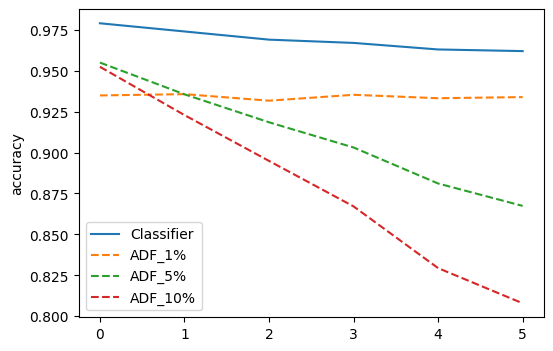

In [211]:
plt.figure(figsize=(6,4))
plt.plot(cset_acc['model'],linestyle='solid',label='Classifier')
plt.plot(cset_acc['adf_1%'],linestyle='dashed',label='ADF_1%')
plt.plot(cset_acc['adf_5%'],linestyle='dashed',label='ADF_5%')
plt.plot(cset_acc['adf_10%'],linestyle='dashed',label='ADF_10%')
plt.ylabel('accuracy')
plt.xlabel('')
plt.legend()
plt.show()

export_df(np.concatenate((c1in,c2in,c3in,c4in,c5in,c6in),axis=0),'plzin')
export_df(np.concatenate((c1outb,c2outb,c3outb,c4outb,c5outb,c6outb),axis=0),'plzoutb')
export_df(np.concatenate((c1outm,c2outm,c3outm,c4outm,c5outm,c6outm),axis=0),'plzoutm')

In [28]:
plzin[:10000]

array([[ 1.72630819,  1.51523283,  2.27580452, ...,  0.20834418,
         0.        ,  0.        ],
       [-1.39829557, -0.05186906, -0.28404083, ..., -0.52000402,
         0.        ,  0.        ],
       [-0.18976508, -0.85518927,  0.41241541, ..., -0.66699942,
         0.        ,  0.        ],
       ...,
       [ 1.19038235, -0.52588356, -0.23716655, ..., -0.07687439,
         0.        ,  0.        ],
       [-1.0760524 , -0.68687769, -0.17427582, ...,  0.48889305,
         0.        ,  0.        ],
       [ 1.33665029, -1.27222354,  0.17415189, ..., -0.24435817,
         0.        ,  0.        ]])

In [37]:
plzin.shape

(60000, 104)

In [36]:
plzin=pd.read_csv('c:/data/dataset/plzin.csv',header=None).to_numpy()

In [37]:
plzin

(60000, 104)

In [29]:
plzin=pd.read_csv('c:/data/dataset/plzin.csv',header=None).to_numpy()
plzoutb=pd.read_csv('c:/data/dataset/plzoutb.csv',header=None).to_numpy()
plzoutm=pd.read_csv('c:/data/dataset/plzoutm.csv',header=None).to_numpy()
plzset=split_set(10000,plzin)
plzbset=split_set(10000,plzoutb)
plzmset=split_set(10000,plzoutm)

In [76]:
din_set=[d1in,d2in,d3in,d4in,d5in,d6in]
doutb_set=[d1outb,d2outb,d3outb,d4outb,d5outb,d6outb]
doutm_set=[d1outm,d2outm,d3outm,d4outm,d5outm,d6outm]
dadf_set=[d1_adf,d2_adf,d3_adf,d4_adf,d5_adf,d6_adf]

In [87]:
cset_accm=table_accm(dmL,cin,coutm,cadf_set)

313/313 [==============================] - 2s 5ms/step - loss: 0.4128 - accuracy: 0.8683


In [88]:
cset_accm

{'model': [0.962, 0.947, 0.931, 0.909, 0.888, 0.868],
 'adf_1%': [0.7003, 0.5259, 0.4007, 0.3443, 0.3366, 0.4034],
 'adf_5%': [0.7319, 0.5545, 0.4207, 0.35, 0.3251, 0.3708],
 'adf_10%': [0.7449, 0.5745, 0.4312, 0.3522, 0.3199, 0.3487]}

In [46]:
c2set_acc=table_acc(dbL,cin_set,coutb_set,cadf_set)
c2set_size=table_size(dbL,cin_set,coutb_set,cadf_set)
c2set_power=table_power(dbL,cin_set,coutb_set,cadf_set)

32/32 [==============================] - 0s 3ms/step


In [189]:
d2set_acc=table_acc(dbL,din_set,doutb_set,dadf_set)
d2set_size=table_size(dbL,din_set,doutb_set,dadf_set)
d2set_power=table_power(dbL,din_set,doutb_set,dadf_set)

32/32 [==============================] - 0s 3ms/step


In [190]:
dset_acc,d2set_acc

({'model': [0.947, 0.956, 0.964, 0.965, 0.974, 0.98],
  'adf_1%': [0.9369, 0.9455, 0.9483, 0.9587, 0.9602, 0.9675],
  'adf_5%': [0.9561, 0.9442, 0.9333, 0.926, 0.9139, 0.9012],
  'adf_10%': [0.953, 0.9294, 0.9059, 0.8814, 0.8548, 0.8265]},
 {'model': [0.977, 0.98, 0.981, 0.98, 0.983, 0.981],
  'adf_1%': [0.9369, 0.9455, 0.9483, 0.9587, 0.9602, 0.9675],
  'adf_5%': [0.9561, 0.9442, 0.9333, 0.926, 0.9139, 0.9012],
  'adf_10%': [0.953, 0.9294, 0.9059, 0.8814, 0.8548, 0.8265]})

In [191]:
dset_size,d2set_size

({'model': [0.021, 0.013, 0.016, 0.018, 0.015, 0.016],
  'adf_1%': [0.033, 0.031, 0.034, 0.03, 0.029, 0.03],
  'adf_5%': [0.12, 0.114, 0.113, 0.106, 0.105, 0.107],
  'adf_10%': [0.203, 0.195, 0.191, 0.188, 0.188, 0.191]},
 {'model': [0.021, 0.016, 0.021, 0.021, 0.016, 0.018],
  'adf_1%': [0.033, 0.031, 0.034, 0.03, 0.029, 0.03],
  'adf_5%': [0.12, 0.114, 0.113, 0.106, 0.105, 0.107],
  'adf_10%': [0.203, 0.195, 0.191, 0.188, 0.188, 0.191]})

In [192]:
dset_power,d2set_power

({'model': [0.942, 0.943, 0.947, 0.938, 0.939, 0.949],
  'adf_1%': [0.932, 0.936, 0.934, 0.942, 0.929, 0.947],
  'adf_5%': [0.97, 0.969, 0.971, 0.974, 0.972, 0.974],
  'adf_10%': [0.98, 0.983, 0.985, 0.985, 0.983, 0.984]},
 {'model': [0.977, 0.978, 0.983, 0.981, 0.98, 0.979],
  'adf_1%': [0.932, 0.936, 0.934, 0.942, 0.929, 0.947],
  'adf_5%': [0.97, 0.969, 0.971, 0.974, 0.972, 0.974],
  'adf_10%': [0.98, 0.983, 0.985, 0.985, 0.983, 0.984]})

In [203]:
ddset_acc,ddset_size,ddset_power

({'model': [0.988, 0.981, 0.981, 0.985],
  'adf_1%': [0.9308, 0.9402, 0.9591, 0.9635],
  'adf_5%': [0.9521, 0.9421, 0.9409, 0.9411],
  'adf_10%': [0.9494, 0.924, 0.9147, 0.9093]},
 {'model': [0.024, 0.028, 0.023, 0.017],
  'adf_1%': [0.022, 0.023, 0.019, 0.021],
  'adf_5%': [0.066, 0.072, 0.066, 0.066],
  'adf_10%': [0.114, 0.128, 0.113, 0.114]},
 {'model': [0.993, 0.99, 0.991, 0.992],
  'adf_1%': [0.91, 0.903, 0.907, 0.917],
  'adf_5%': [0.96, 0.957, 0.957, 0.963],
  'adf_10%': [0.977, 0.976, 0.979, 0.979]})

In [78]:
dset_acc=table_acc(dbL_25_5,din_set,doutb_set,dadf_set)
dset_size=table_size(dbL_25_5,din_set,doutb_set,dadf_set)
dset_power=table_power(dbL_25_5,din_set,doutb_set,dadf_set)

32/32 [==============================] - 0s 2ms/step


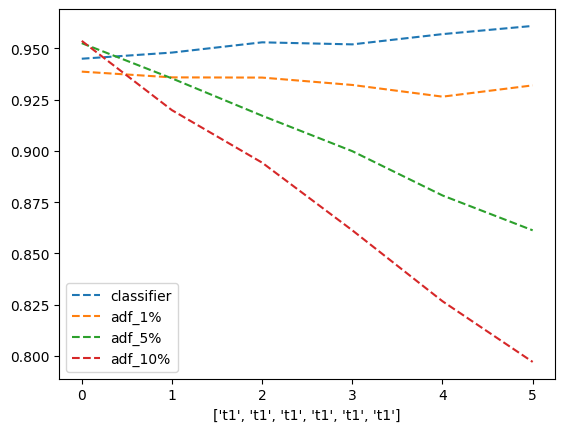

In [213]:
#plt.plot(dset_acc['model'],linestyle='dashed')
#plt.plot(dset_acc['adf_1%'],linestyle='dashed')
#plt.plot(dset_acc['adf_5%'],linestyle='dashed')
#plt.plot(dset_acc['adf_10%'],linestyle='dashed')
pset=[0.15,0.3,0.45,0.6,0.75,0.9]
plt.plot(cset_acc['model'],linestyle='solid',label='classifier')
plt.plot(cset_acc['adf_1%'],linestyle='dashed',label='adf_1%')
plt.plot(cset_acc['adf_5%'],linestyle='dashed',label='adf_5%')
plt.plot(cset_acc['adf_10%'],linestyle='dashed',label='adf_10%')
plt.ylabel('accuracy')
plt.xlabel('dataset')
plt.legend()
#plt.legend(['dm','dadf1','dadf5','dadf10','cm','cadf1','cadf5','cadf10'])
plt.show()

In [173]:
cacc=table_acc(dbL,cin,coutb,cadf_set)

313/313 [==============================] - 2s 6ms/step - loss: 0.1365 - accuracy: 0.9582


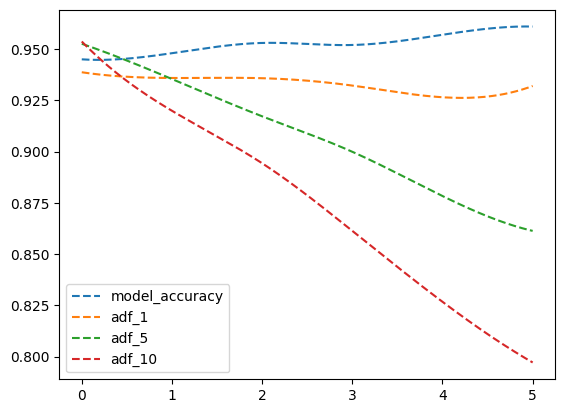

In [146]:
y=list(cset_acc.values())[0]
spl=make_interp_spline(x,y,k=3)
mspl=spl(x_new)
#plt.plot(x, y, 'o', label='Original Data')
plt.plot(x_new, spl(x_new), label='model_accuracy',linestyle='--')
y=list(cset_acc.values())[1]
spl=make_interp_spline(x,y,k=3)
plt.plot(x_new,spl(x_new),label='adf_1',linestyle='--')
y=list(cset_acc.values())[2]
spl=make_interp_spline(x,y,k=3)
plt.plot(x_new,spl(x_new),label='adf_5',linestyle='--')
y=list(cset_acc.values())[3]
spl=make_interp_spline(x,y,k=3)
plt.plot(x_new,spl(x_new),label='adf_10',linestyle='--')
plt.legend()
#plt.savefig('foo.png')

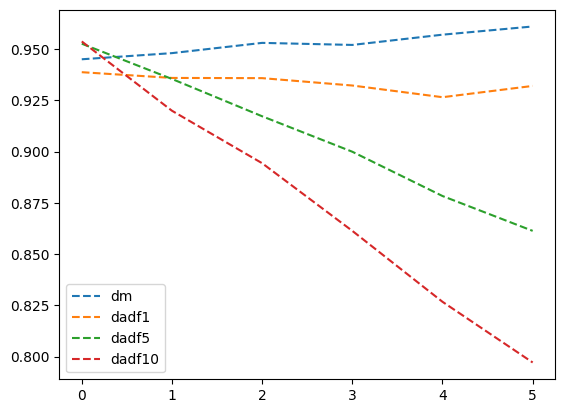

In [101]:
#plt.plot(dset_acc['model'],linestyle='dashed')
#plt.plot(dset_acc['adf_1%'],linestyle='dashed')
#plt.plot(dset_acc['adf_5%'],linestyle='dashed')
#plt.plot(dset_acc['adf_10%'],linestyle='dashed')
plt.plot(cset_acc['model'],linestyle='dashed')
plt.plot(cset_acc['adf_1%'],linestyle='dashed')
plt.plot(cset_acc['adf_5%'],linestyle='dashed')
plt.plot(cset_acc['adf_10%'],linestyle='dashed')
#
plt.legend(['dm','dadf1','dadf5','dadf10','cm','cadf1','cadf5','cadf10'])
plt.show()

In [99]:
dset_acc,cset_acc

({'model': [0.947, 0.956, 0.964, 0.965, 0.974, 0.98],
  'adf_1%': [0.9369, 0.9455, 0.9483, 0.9587, 0.9602, 0.9675],
  'adf_5%': [0.9561, 0.9442, 0.9333, 0.926, 0.9139, 0.9012],
  'adf_10%': [0.953, 0.9294, 0.9059, 0.8814, 0.8548, 0.8265]},
 {'model': [0.945, 0.948, 0.953, 0.952, 0.957, 0.961],
  'adf_1%': [0.9387, 0.9359, 0.9358, 0.9322, 0.9265, 0.932],
  'adf_5%': [0.9526, 0.9354, 0.9172, 0.8999, 0.8783, 0.8613],
  'adf_10%': [0.9537, 0.9199, 0.8943, 0.8613, 0.8267, 0.7971]})

In [81]:
dset_size,cset_size

({'model': [0.021, 0.013, 0.016, 0.018, 0.015, 0.016],
  'adf_1%': [0.033, 0.031, 0.034, 0.03, 0.029, 0.03],
  'adf_5%': [0.12, 0.114, 0.113, 0.106, 0.105, 0.107],
  'adf_10%': [0.203, 0.195, 0.191, 0.188, 0.188, 0.191]},
 {'model': [0.035, 0.04, 0.037, 0.037, 0.039, 0.037],
  'adf_1%': [0.056, 0.067, 0.066, 0.069, 0.074, 0.068],
  'adf_5%': [0.143, 0.151, 0.149, 0.145, 0.152, 0.15],
  'adf_10%': [0.205, 0.231, 0.214, 0.218, 0.225, 0.223]})

In [82]:
dset_power,cset_power

({'model': [0.942, 0.943, 0.947, 0.938, 0.939, 0.949],
  'adf_1%': [0.932, 0.936, 0.934, 0.942, 0.929, 0.947],
  'adf_5%': [0.97, 0.969, 0.971, 0.974, 0.972, 0.974],
  'adf_10%': [0.98, 0.983, 0.985, 0.985, 0.983, 0.984]},
 {'model': [0.942, 0.943, 0.945, 0.937, 0.948, 0.943],
  'adf_1%': [0.938, 0.937, 0.937, 0.934, 0.928, 0.928],
  'adf_5%': [0.97, 0.973, 0.971, 0.967, 0.97, 0.967],
  'adf_10%': [0.982, 0.985, 0.983, 0.98, 0.982, 0.978]})

In [38]:
cset_acc

{'model': [0.945, 0.948, 0.953, 0.952, 0.957, 0.961],
 'adf_1%': [0.9387, 0.9359, 0.9358, 0.9322, 0.9265, 0.932],
 'adf_5%': [0.9526, 0.9354, 0.9172, 0.8999, 0.8783, 0.8613],
 'adf_10%': [0.9537, 0.9199, 0.8943, 0.8613, 0.8267, 0.7971]}

In [64]:
cset_size

{'model': [0.035, 0.04, 0.037, 0.037, 0.039, 0.037],
 'adf_1%': [0.056, 0.067, 0.066, 0.069, 0.074, 0.068],
 'adf_5%': [0.143, 0.151, 0.149, 0.145, 0.152, 0.15],
 'adf_10%': [0.205, 0.231, 0.214, 0.218, 0.225, 0.223]}

In [65]:
cset_power

{'model': [0.942, 0.943, 0.945, 0.937, 0.948, 0.943],
 'adf_1%': [0.938, 0.937, 0.937, 0.934, 0.928, 0.928],
 'adf_5%': [0.97, 0.973, 0.971, 0.967, 0.97, 0.967],
 'adf_10%': [0.982, 0.985, 0.983, 0.98, 0.982, 0.978]}

In [63]:
cset_size=table_size(dbL_25_5,cin_set,coutb_set,cadf_set)

282/282 [==============================] - 1s 3ms/step


In [62]:
cset_power=table_power(dbL_25_5,cin_set,coutb_set,cadf_set)

32/32 [==============================] - 0s 3ms/step


In [112]:
## 일정한 패턴이 없는 것 같은데?
cset_acc

{'model': [0.944, 0.945, 0.951, 0.956, 0.958, 0.96],
 'adf_1%': [0.9351, 0.9373, 0.9363, 0.9375, 0.9347, 0.9336],
 'adf_5%': [0.9528, 0.9382, 0.9176, 0.9013, 0.8823, 0.8663],
 'adf_10%': [0.9531, 0.9249, 0.8919, 0.8638, 0.832, 0.7999]}

In [113]:
cset_acc,dset_acc

({'model': [0.945, 0.948, 0.953, 0.952, 0.957, 0.961],
  'adf_1%': [0.9387, 0.9359, 0.9358, 0.9322, 0.9265, 0.932],
  'adf_5%': [0.9526, 0.9354, 0.9172, 0.8999, 0.8783, 0.8613],
  'adf_10%': [0.9537, 0.9199, 0.8943, 0.8613, 0.8267, 0.7971]},
 {'model': [0.947, 0.956, 0.964, 0.965, 0.974, 0.98],
  'adf_1%': [0.9369, 0.9455, 0.9483, 0.9587, 0.9602, 0.9675],
  'adf_5%': [0.9561, 0.9442, 0.9333, 0.926, 0.9139, 0.9012],
  'adf_10%': [0.953, 0.9294, 0.9059, 0.8814, 0.8548, 0.8265]})

Text(0.5, 1.0, 'accuracy ')

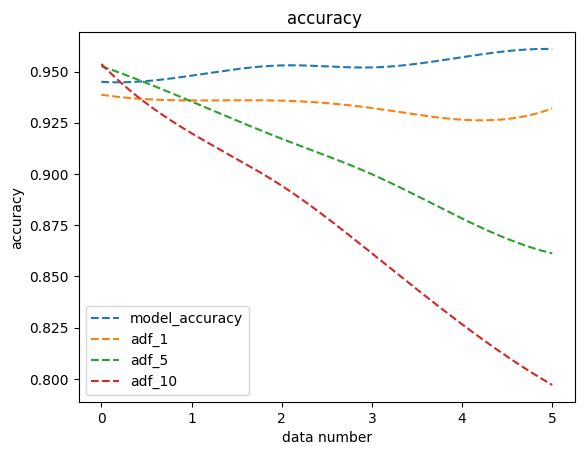

In [167]:
y=list(cset_acc.values())[0]
spl=make_interp_spline(x,y,k=3)
mspl=spl(x_new)
#plt.plot(x, y, 'o', label='Original Data')
plt.plot(x_new, spl(x_new), label='model_accuracy',linestyle='--')
y=list(cset_acc.values())[1]
spl=make_interp_spline(x,y,k=3)
plt.plot(x_new,spl(x_new),label='adf_1',linestyle='--')
y=list(cset_acc.values())[2]
spl=make_interp_spline(x,y,k=3)
plt.plot(x_new,spl(x_new),label='adf_5',linestyle='--')
y=list(cset_acc.values())[3]
spl=make_interp_spline(x,y,k=3)
plt.plot(x_new,spl(x_new),label='adf_10',linestyle='--')
plt.legend()
plt.xlabel('data number')
plt.ylabel('accuracy')
plt.title('accuracy ')
#plt.savefig('foo.png')

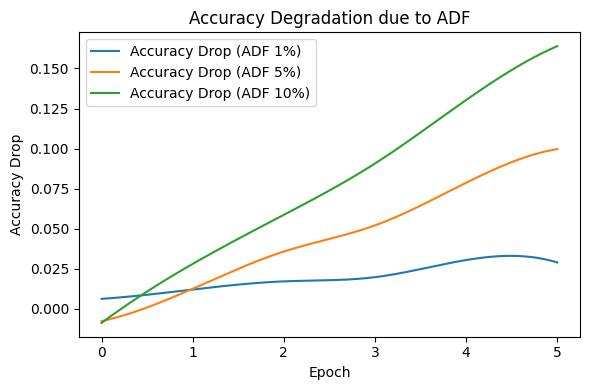

In [160]:
model_accuracy=mspl
adf_1=spl1(x_new)
adf_5=spl2(x_new)
adf_10=spl3(x_new)
delta_1 = model_accuracy - adf_1
delta_5 = model_accuracy - adf_5
delta_10 = model_accuracy - adf_10

plt.figure(figsize=(6, 4))
plt.plot(x_new, delta_1, label='Accuracy Drop (ADF 1%)')
plt.plot(x_new, delta_5, label='Accuracy Drop (ADF 5%)')
plt.plot(x_new, delta_10, label='Accuracy Drop (ADF 10%)')
plt.xlabel("Epoch")
plt.ylabel("Accuracy Drop")
plt.title("Accuracy Degradation due to ADF")
plt.legend()
#plt.grid(True)
plt.tight_layout()
plt.show()

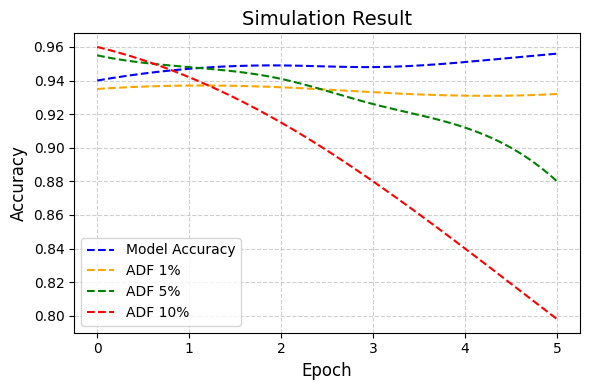

In [147]:
# 예시 데이터
x = np.array([0, 1, 2, 3, 4, 5])
model_accuracy = np.array([0.94, 0.947, 0.949, 0.948, 0.951, 0.956])
adf_1 = np.array([0.935, 0.937, 0.936, 0.933, 0.931, 0.932])
adf_5 = np.array([0.955, 0.948, 0.941, 0.926, 0.912, 0.88])
adf_10 = np.array([0.96, 0.942, 0.915, 0.88, 0.84, 0.798])
# 부드러운 곡선 만들기
x_new = np.linspace(x.min(), x.max(), 300)
def smooth(x, y): return make_interp_spline(x, y, k=3)(x_new)
# 플롯 설정
plt.figure(figsize=(6, 4))
plt.plot(x_new, smooth(x, model_accuracy), label='Model Accuracy', linestyle='--', color='blue')
plt.plot(x_new, smooth(x, adf_1), label='ADF 1%', linestyle='--', color='orange')
plt.plot(x_new, smooth(x, adf_5), label='ADF 5%', linestyle='--', color='green')
plt.plot(x_new, smooth(x, adf_10), label='ADF 10%', linestyle='--', color='red')
# 제목, 라벨, 눈금 등
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.title("Simulation Result", fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
# 고해상도 저장
plt.savefig("plot_for_paper.png", dpi=300)
plt.show()

In [168]:
x_new=np.linspace(x[0],x[-1],300)

In [37]:
dbL=Sequential([
    LSTM(30,input_shape=(100,1)),
    Dense(2,activation='softmax')
    ])
dbL.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='rmsprop')


In [43]:
early_stopping = EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)
checkpoint=ModelCheckpoint('c:/data/model_weights/dbL.hdf5',monitor='val_loss',verbose=0,mode='min',save_best_only=True)
fit_history=dbL.fit(to_put(tin_m,100),toutb_m,
                         validation_data=(to_put(vin_m,100),voutb_m),batch_size=1000,epochs=300,
                         callbacks=[checkpoint,early_stopping],verbose=0)

In [ ]:
## use rmsprop or adam?
## 15_3,25_5,35_7,5_75
## 15_3
def cbL(inputs,outputb,proportion):
    base='c:/data/model_weights/0303/cbL'+proportion+'.hdf5'
    model=Sequential([
        LSTM(30,input_shape=(100,1)),
        Dense(2,activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='rmsprop')
    early_stopping = EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)
    checkpoint=ModelCheckpoint(base,
                           monitor='val_loss',verbose=0,mode='min',save_best_only=True)
    fit_history=model.fit(to_put(inputs[0],100),outputb[0],
                         validation_data=(to_put(inputs[1],100),outputb[1]),batch_size=1000,epochs=300,
                         callbacks=[checkpoint,early_stopping],verbose=0)
    return model,fit_history

In [193]:
din_15_3,doutb_15_3,doutm_15_3=load_d2set(15,3,80000,110000)
din_25_5,doutb_25_5,doutm_25_5=load_d2set(25,5,80000,110000)
din_35_7,doutb_35_7,doutm_35_7=load_d2set(35,7,80000,110000)
din_5_75,doutb_5_75,doutm_5_75=load_d2set(5,75,80000,110000)

In [196]:
ddin=[din_15_3[2],din_25_5[2],din_35_7[2],din_5_75[2]]
ddoutb=[doutb_15_3[2],doutb_25_5[2],doutb_35_7[2],doutb_5_75[2]]

In [199]:
ddadf=[d15_3_adf,d25_5_adf,d35_7_adf,d5_75_adf]

In [201]:
ddset_acc=table_acc(dbL,ddin,ddoutb,ddadf)
ddset_size=table_size(dbL,ddin,ddoutb,ddadf)
ddset_power=table_power(dbL,ddin,ddoutb,ddadf)

79/79 [==============================] - 0s 4ms/step


### c2set만 해도 충분하다

In [48]:
c2set_acc

{'model': [0.965, 0.959, 0.958, 0.951, 0.944, 0.945],
 'adf_1%': [0.9337, 0.9347, 0.9324, 0.9333, 0.9311, 0.9352],
 'adf_5%': [0.9521, 0.9348, 0.9216, 0.901, 0.8795, 0.8716],
 'adf_10%': [0.9536, 0.9232, 0.8991, 0.862, 0.8342, 0.8093]}

In [49]:
p = 0.3
label = rf"$\mathrm{{dataset}}_{{{p}}}$"

In [50]:
label

'$\\mathrm{dataset}_{0.3}$'

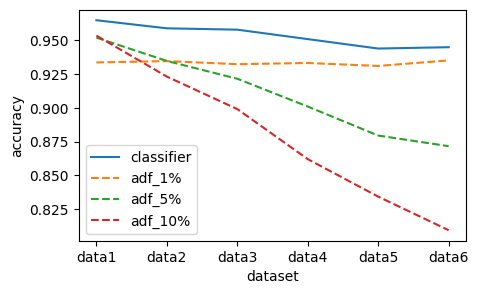

<Figure size 640x480 with 0 Axes>

In [58]:
plt.figure(figsize=(5,3))
x=['data1','data2','data3','data4','data5','data6']
plt.plot(x,c2set_acc['model'],linestyle='solid',label='classifier')
plt.plot(x,c2set_acc['adf_1%'],linestyle='dashed',label='adf_1%')
plt.plot(x,c2set_acc['adf_5%'],linestyle='dashed',label='adf_5%')
plt.plot(x,c2set_acc['adf_10%'],linestyle='dashed',label='adf_10%')
plt.ylabel('accuracy')
plt.xlabel('dataset')

plt.legend()
#plt.legend(['dm','dadf1','dadf5','dadf10','cm','cadf1','cadf5','cadf10'])
plt.show()
plt.savefig('combineacc.png')

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)
checkpoint=ModelCheckpoint('c:/data/model_weights/dbL.hdf5',monitor='val_loss',verbose=0,mode='min',save_best_only=True)
fit_history=dbL.fit(to_put(tin_m,100),toutb_m,
                         validation_data=(to_put(vin_m,100),voutb_m),batch_size=1000,epochs=300,
                         callbacks=[checkpoint,early_stopping],verbose=0)

In [27]:
dmL=Sequential([
    LSTM(30,input_shape=(100,1)),
    Dense(3,activation='softmax')
])
dmL.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='rmsprop')
early_stopping = EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)
checkpoint=ModelCheckpoint('c:/data/model_weights/dmL.hdf5',monitor='val_loss',verbose=0,mode='min',save_best_only=True)
#나에게 너를 초대할 뿐야 신비로운 너의 모습 나에게는 사랑인걸
# 조금씩 다가오는 널 느낄 수록 신비로운 너의 모습 나에게는 사랑인 걸
# 조금씩 멈춰지는 시간 속의 널 어둠 속의 비처럼 다가설 수 어둠 속의 한 줄기 빛처럼 느껴~ my love~
dmL_history=dmL.fit(to_put(tin,100),toutm,
                         validation_data=(to_put(vin,100),voutm),batch_size=1000,epochs=300,
                         callbacks=[checkpoint,early_stopping],verbose=0)

In [28]:
dmL.evaluate(to_put(tein,100),teoutm)

938/938 [==============================] - 4s 4ms/step - loss: 0.1431 - accuracy: 0.9447


[0.14312489330768585, 0.9447333216667175]

In [26]:
tin,toutb,toutm=dgenerator(10000,0.5,100)
vin,voutb,voutm=dgenerator(30000,0.5,100)
tein,teoutb,teoutm=dgenerator(30000,0.5,100)

In [49]:
fin=pd.read_csv('c:/data/dataset/fin.csv',header=None).to_numpy()

In [30]:
export_df(np.concatenate((tin,vin,tein),axis=0),'fin')
export_df(np.concatenate((toutb,voutb,teoutb),axis=0),'foutb')
export_df(np.concatenate((toutm,voutm,teoutm),axis=0),'foutm')
np.save('c:/data/model_weights/0303/fte_adf.npy',fte_adf)

In [64]:
dtrin,dtroutb,dtroutm=dgenerator(100000,0.5,100)
dvin,dvoutb,dvoutm=dgenerator(30000,0.5,100)
dtein,dteoutb,dteoutm=dgenerator(10000,0.5,100)
export_df(np.concatenate((dtrin,dvin,dtein),axis=0),'fdin')
export_df(np.concatenate((dtroutb,dvoutb,dteoutb),axis=0),'fdoutb')
export_df(np.concatenate((dtroutm,dvoutm,dteoutm),axis=0),'fdoutm')

In [67]:
dbL=Sequential([
    LSTM(30,input_shape=(100,1)),
    Dense(2,activation='softmax')
])
dbL.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='rmsprop')
early_stopping = EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True)
checkpoint=ModelCheckpoint('c:/data/model_weights/dbL.hdf5',monitor='val_loss',verbose=0,mode='min',save_best_only=True)
dbL_history=dbL.fit(to_put(dtrin,100),dtroutb,
                         validation_data=(to_put(dvin,100),dvoutb),batch_size=1000,epochs=300,
                         callbacks=[checkpoint,early_stopping],verbose=0)

In [68]:
dmL=Sequential([
    LSTM(30,input_shape=(100,1)),
    Dense(3,activation='softmax')
])
dmL.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='rmsprop')
early_stopping = EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True)
checkpoint=ModelCheckpoint('c:/data/model_weights/dmL.hdf5',monitor='val_loss',verbose=0,mode='min',save_best_only=True)
dmL_history=dmL.fit(to_put(dtrin,100),dtroutm,
                         validation_data=(to_put(dvin,100),dvoutm),batch_size=1000,epochs=300,
                         callbacks=[checkpoint,early_stopping],verbose=0)

In [69]:
dtein_adf=adf_test(dtein)
np.save('c:/data/dtein_adf.npy',dtein_adf)

In [217]:
idx0,idx1,idx2=extin(dteoutm)

In [218]:
dmL.evaluate(to_put(dtein,100),dteoutm)

313/313 [==============================] - 1s 5ms/step - loss: 0.1000 - accuracy: 0.9614


[0.09997593611478806, 0.9613999724388123]

In [227]:
m_acc=table_accm(dmL,cin_set,coutm_set,cadf_set)

313/313 [==============================] - 1s 4ms/step - loss: 0.3931 - accuracy: 0.8745


In [230]:
dm_acc=table_accm(dmL,[dtein],[dteoutm],[dtein_adf])

313/313 [==============================] - 1s 4ms/step - loss: 0.1000 - accuracy: 0.9614


In [231]:
dm_acc

{'model': [0.961], 'adf_1%': [0.9307], 'adf_5%': [0.9013], 'adf_10%': [0.8563]}

In [15]:
def  table_size(model,input_set,output_set,adf_set):
        result={}
        classifier_size=[]
        for inputs,outputs in zip(input_set,output_set):
            classifier_size.append(model_size(model,inputs,outputs))
        result['model']=classifier_size

        size_adf1=[]
        for adf,inputs,outputs in zip(adf_set,input_set,output_set):
            size_adf1.append(adf_size(adf,inputs,outputs,'1%'))
        result['adf_1%']=size_adf1
        
        size_adf5=[]
        for adf,inputs,outputs in zip(adf_set,input_set,output_set):
            size_adf5.append(adf_size(adf,inputs,outputs,'5%'))
        result['adf_5%']=size_adf5
        
        size_adf10=[]
        for adf,inputs,outputs in zip(adf_set,input_set,output_set):
            size_adf10.append(adf_size(adf,inputs,outputs,'10%'))
        result['adf_10%']=size_adf10
        return result
    
def adf_size(adf,inputs,outputs,sig): # 이건 binary일 경우. 그니까 accu
    in0,out0,idx0=sort_H0(inputs,outputs)
    size=np.round(np.sum(adf[sig]['bi'][idx0],axis=0)[1]/len(idx0),3)
    return size

In [228]:
# dmL은 0.25/0.25/0.5
# 0.15/0.3/0.45/0.6/0.75/0.9
m_acc

{'model': [0.965, 0.949, 0.926, 0.913, 0.89, 0.874],
 'adf_1%': [0.9217, 0.9139, 0.8914, 0.8858, 0.8686, 0.8582],
 'adf_5%': [0.937, 0.9007, 0.8599, 0.8293, 0.7889, 0.7548],
 'adf_10%': [0.9282, 0.8715, 0.8118, 0.761, 0.6987, 0.6513]}

In [234]:
idx=idx2
outputs=dteoutm[idx2]
inputs=dtein[idx2]
#
print(np.round(dmL.evaluate(to_put(inputs,100),outputs)[1],3))
print(acc_cal(dtein_adf['1%']['multi'][idx],outputs))
print(acc_cal(dtein_adf['5%']['multi'][idx],outputs))
print(acc_cal(dtein_adf['10%']['multi'][idx],outputs))

79/79 [==============================] - 1s 7ms/step - loss: 0.1114 - accuracy: 0.9652
0.965
0.9336
0.7896
0.6516


In [235]:
idx=idx1
outputs=dteoutm[idx]
inputs=dtein[idx]
#
print(np.round(dmL.evaluate(to_put(inputs,100),outputs)[1],3))
print(acc_cal(dtein_adf['1%']['multi'][idx],outputs))
print(acc_cal(dtein_adf['5%']['multi'][idx],outputs))
print(acc_cal(dtein_adf['10%']['multi'][idx],outputs))

79/79 [==============================] - 1s 7ms/step - loss: 0.2043 - accuracy: 0.9160
0.916
0.9124
0.8684
0.8076


In [236]:
idx=idx0
outputs=dteoutm[idx]
inputs=dtein[idx]
#
print(np.round(dmL.evaluate(to_put(inputs,100),outputs)[1],3))
print(acc_cal(dtein_adf['1%']['multi'][idx],outputs))
print(acc_cal(dtein_adf['5%']['multi'][idx],outputs))
print(acc_cal(dtein_adf['10%']['multi'][idx],outputs))

157/157 [==============================] - 1s 6ms/step - loss: 0.0421 - accuracy: 0.9822
0.982
0.9384
0.9736
0.983


In [213]:
# array: 3d output vector
def extin(array):
    '''
    note that 
    idx0 means stationary time series index
    idx1 means unit root time series idx having 1 unit root
    idx2 means unit root time series idx having 2 unit root
    '''
    idx0=[]
    idx1=[]
    idx2=[]
    for i,x in enumerate(array):
        if x[0]==1:
            idx2.append(i)
        elif x[1]==1:
            idx1.append(i)
        elif x[-1]==1:
            idx0.append(i)
    return idx0,idx1,idx2

In [246]:
# d일 떄는 그냥 combine 없으니까 case1으로 생성해주면 된다.
# p: proportion of Ho dataset
# mdd
def dmgenerator(timesteps):
    inputs=[]
    outputs_b=[]
    outputs_m=[]

    zero=10000
    one=10000 # stationary
    two=10000
    #
    while zero:
        zero-=1
        phi1,phi2=stationary_ar2()
        series=stationary_series_ar2(phi1,phi2,100)
        inputs.append(series)
        outputs_b.append([0,1])
        outputs_m.append([0,0,1])
    diff_order=1
    while one:
        one-=1
        phi1,phi2=stationary_ar2()
        series=unitroot_series_1(phi1,phi2,diff_order,timesteps,1)
        inputs.append(series)
        outputs_b.append([1,0])
        outputs_m.append([0,1,0])
    diff_order=2
    while two:
        two-=1
        phi1,phi2=stationary_ar2()
        series=unitroot_series_1(phi1,phi2,diff_order,timesteps,1)
        inputs.append(series)
        outputs_b.append([1,0])
        outputs_m.append([1,0,0])
    #
    inputs=np.array(inputs)
    outputs_b=np.array(outputs_b)
    outputs_m=np.array(outputs_m)
    assert n==len(inputs)==len(outputs_b)==len(outputs_m)
    return inputs,outputs_b,outputs_m

In [247]:
minn,moutb,moutm=dmgenerator(100)# ur0,ur1,ur2순 10000개씩

In [248]:
print(np.sum(moutm[:10000],axis=0))
print(np.sum(moutm[10000:20000],axis=0))
print(np.sum(moutm[20000:30000],axis=0))

[    0     0 10000]
[    0 10000     0]
[10000     0     0]


In [249]:
m_adf=adf_test(minn)

In [255]:
interval=10000
i=0
dmL.evaluate(to_put(minn[interval*i:interval*(i+1)],100),moutm[interval*i:interval*(i+1)])[1]

313/313 [==============================] - 1s 5ms/step - loss: 0.0450 - accuracy: 0.9831


0.9830999970436096

In [258]:
np.round(m_accuracy,3)

array([0.983, 0.915, 0.969])

In [256]:
m_accuracy=[dmL.evaluate(to_put(minn[interval*i:interval*(i+1)],100),moutm[interval*i:interval*(i+1)])[1] for i in range(3)]

313/313 [==============================] - 1s 4ms/step - loss: 0.1050 - accuracy: 0.9694


In [261]:
adf1_accuracy=[acc_cal(m_adf['1%']['multi'][interval*i:interval*(i+1)],moutm[interval*i:interval*(i+1)]) for i in range(3)]
adf5_accuracy=[acc_cal(m_adf['5%']['multi'][interval*i:interval*(i+1)],moutm[interval*i:interval*(i+1)]) for i in range(3)]
adf10_accuracy=[acc_cal(m_adf['10%']['multi'][interval*i:interval*(i+1)],moutm[interval*i:interval*(i+1)]) for i in range(3)]

In [265]:
m_accuracy=np.round(m_accuracy,3)
m_accuracy

In [272]:
print(m_accuracy)
print(np.round(adf1_accuracy,3))
print(np.round(adf5_accuracy,3))
print(np.round(adf10_accuracy,3))

[0.983 0.915 0.969]
[0.935 0.912 0.94 ]
[0.972 0.874 0.799]
[0.982 0.8   0.666]


In [1]:
2025-1949+1

77

In [269]:
## ADF검정에서 높은 유의수준은 웬만하면 unit root series라고 판단한다는 거니까 당근 높을 수밖에 없지. > 이것까지 해석에 ㄱㄱ
## ur0,ur1,ur2순 
print(np.round(diff_adf1,3))
print(np.round(diff_adf5,3))
print(np.round(diff_adf10,3))

[0.048 0.003 0.029]
[0.011 0.041 0.17 ]
[0.001 0.115 0.303]


In [267]:
diff_adf1=[m_accuracy[i]-adf1_accuracy[i]  for i in range(3)]
diff_adf5=[m_accuracy[i]-adf5_accuracy[i]  for i in range(3)]
diff_adf10=[m_accuracy[i]-adf10_accuracy[i]  for i in range(3)]

In [ ]:
diff_adf1=[m_accuracy[i]-adf1_accuracy[i] for i in range(3)]
diff_adf5=[m_accuracy[i]-adf5_accuracy[i] for i in range(3)]
diff_adf10=[m_accuracy[i]-adf10_accuracy[i] for i in range(3)]

In [251]:
np.save('c:/data/m_adf.npy',m_adf)

In [250]:
export_df(minn,'minn')
export_df(moutb,'moutb')
export_df(moutm,'moutm')